In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import time

## No vectorizada

In [31]:
def price_barrier_option(option_type, ticker, K, barrier_price):
    # Descargar precios históricos
    data = yf.download(ticker, start='2022-01-01', end='2025-03-15')['Close']['SPY']

    daily_returns = data.pct_change().dropna()

    # Parámetros
    S0 = float(data.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    r = 0.10
    T_days = 252
    T = 1  # años
    dt = T / T_days
    num_simulations = 100_000
    # Simulaciones
    Z = np.random.normal(0, 1, (num_simulations, T_days))


    price_matrix = np.zeros((num_simulations, T_days + 1))
    payoffs = np.zeros(num_simulations)

    for i in range(num_simulations):
        path = [S0]
        barrier_breached = False
        for t in range(1, T_days + 1):
            St = path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[i, t-1])
            path.append(St)

            if St > barrier_price:  # up-and-out
                barrier_breached = True
                break


        if not barrier_breached:
            ST = path[-1]
            if option_type == 'put':
                payoffs[i] = max(K - ST, 0)
            else:
                payoffs[i] = max(ST - K, 0)


    price = np.exp(-r * T) * np.mean(payoffs)
    return S0, price

## Vectorizada

In [32]:
def price_barrier_option_vectorizado(option_type, ticker, K, barrier_price):
    # Descargar precios históricos
    data = yf.download(ticker, start='2022-01-01', end='2025-03-15')['Close']['SPY']
    daily_returns = data.pct_change().dropna()

    # Parámetros
    S0 = float(data.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    r = 0.10
    T_days = 252
    T = 1  # años
    dt = T / T_days
    num_simulations = 100_000
    Z = np.random.normal(0, 1, (num_simulations, T_days))

    returns = (r - 0.5 * sigma**2) * dt  +  sigma * np.sqrt(dt) * Z
    prices = S0 * np.cumprod(1 + returns, axis=1)

    ST = prices[:, -1]

    barrier_breached = np.any(prices >= barrier_price, axis=1)

    if option_type == 'call':

        payoff_barrier = np.where(~barrier_breached, np.maximum(ST - K, 0), 0 )

        # Payoff opcion sin barrera
        payoff_plain = np.maximum(ST - K, 0)

    elif option_type == 'put':

        payoff_barrier = np.where(~barrier_breached, np.maximum(K - ST, 0), 0 )
        # Payoff opcion sin barrera
        payoff_plain = np.maximum(K - ST, 0)

    price_barrier = np.exp(-r * T) * np.mean(payoff_barrier)
    price_plain = np.exp(-r * T) * np.mean(payoff_plain)
    price_difference = price_plain - price_barrier

    return {
        'S0': S0
        ,'price_plain': price_plain
        ,'price_barrier': price_barrier
        ,'price_difference': price_difference
        }

In [33]:
price_barrier_option( 'put', 'SPY', 620, 744)

[*********************100%***********************]  1 of 1 completed


(561.1220092773438, 39.23939447892514)

Con K y option_type fijo, para barrier price desde 1`*`K  hasta 1.2`*`K. Grafica el precio de las opciones con y sin barrera.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

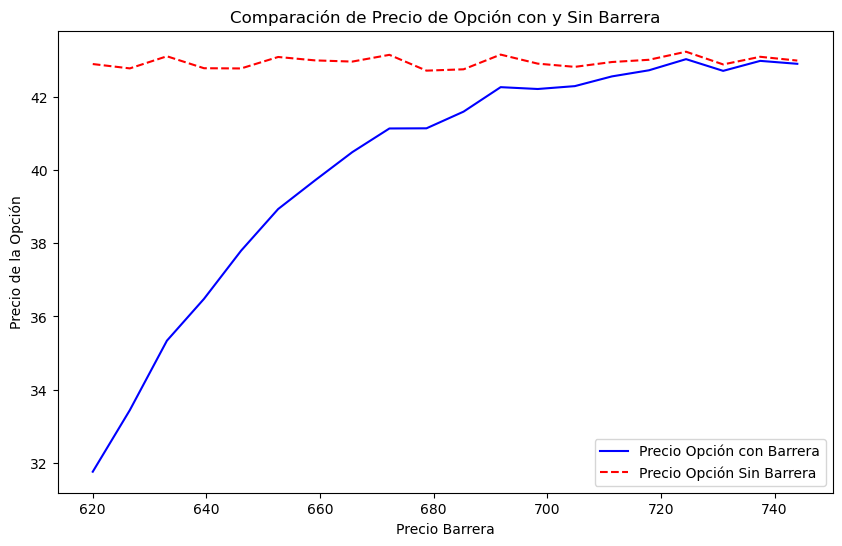

In [34]:
barrier_prices = np.linspace(620, 1.2 * 620, 20)


price_barriers = []
price_plains = []

for barrier_price in barrier_prices:
    result = price_barrier_option_vectorizado('put', 'SPY', 620, barrier_price)
    price_b = result['price_barrier']
    price_p = result['price_plain']
    price_barriers.append(price_b) 
    price_plains.append(price_p) 


plt.figure(figsize=(10, 6))
plt.plot(barrier_prices, price_barriers, label='Precio Opción con Barrera', color='blue')
plt.plot(barrier_prices, price_plains, label='Precio Opción Sin Barrera', color='red', linestyle='--')
plt.xlabel('Precio Barrera')
plt.ylabel('Precio de la Opción')
plt.title('Comparación de Precio de Opción con y Sin Barrera')
plt.legend()

Compara el tiempo de cómputo para 1M de simulaciones entre la opción vectorizada y no vectorizada

#### No vectorizado

In [35]:
start_time = time.time()
price_barrier_option('put', 'SPY', 620, 630)
end_time = time.time()
tiempo= end_time-   start_time
tiempo


[*********************100%***********************]  1 of 1 completed


42.031067848205566

In [36]:
start_time = time.time()
price_barrier_option_vectorizado('put', 'SPY', 620, 630)
end_time = time.time()
tiempo= end_time-   start_time
tiempo


[*********************100%***********************]  1 of 1 completed


1.28078031539917